In [2]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import scipy
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,   # “variance-ratio” or CH score
)
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from sklearn.decomposition import PCA

## Prepare AMIGOS data for clustering
Transpose and standardize 

In [3]:
# load amigos data
pers_amigos = pd.read_csv("/Users/anna/Downloads/Scriptie_code/Amigos/Participants_Personality/Personalities-Tabel 1.csv", 
                          delimiter=";", 
                          decimal=',')

# Transpose dataframe so that columns are now rows and vice versa
df_a = pers_amigos.T                                                        # transpose
df_a.columns = df_a.iloc[0]                                                 # set first row as header
df_a= df_a.drop(index=df_a.index[0])                                        # drop the header row from data
df_a = df_a.reset_index().rename(columns={'index': 'ParticipantID'})        # create new column that was previously index
df_a = df_a.rename_axis(None, axis=1)                                       # rename index to none


# rename & reorder column names for consistency
df_a.rename(columns=
            {'Creativity (openness)': 'Openness'} ,
            inplace=True)                                                   # rename column
df_a['Neuroticism'] = -df_a['Emotional Stability']                          # invert Emotional Stability to create Neuroticism
df_a = df_a.drop(columns=['Emotional Stability'])                           # Drop Emotional Stability and update feature list

# Standardize trait columns to mean=0 and std=1. 
columns = ['Extroversion', 'Agreeableness', 'Conscientiousness', 'Openness', 'Neuroticism'] 
scaler = StandardScaler()
df_a[columns] = scaler.fit_transform(df_a[columns].astype(float)) 

# X = df_a[columns].astype(float).values
# df_a = StandardScaler().fit_transform(X)
# scale because we care about how each person compares to the rest on that specific trait
# therefore the model focuses on relative differences between people. Kmeans is sensitive to feature scales


# plot dist and outliers for amigos

In [4]:
# for trait in columns:
#     plt.figure()
#     sns.histplot(df_a[trait], kde=True)
#     plt.title(f"Distribution of {trait}")
#     plt.xlabel("Standardized value (z-score)")
#     plt.ylabel("Count")
#     plt.show()


## K-Means clustering


In [5]:

# Run k-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init = 100)
df_a['K_Cluster'] = kmeans.fit_predict(df_a[columns])

#Assign the cluster labels back to the DataFrame
df_a['K_Cluster'].value_counts() # cluster counts:   


K_Cluster
1    19
2    11
0     8
Name: count, dtype: int64

In [6]:
# run internal quality metrics
sil = silhouette_score(df_a[columns], df_a["K_Cluster"])
db  = davies_bouldin_score(df_a[columns], df_a["K_Cluster"])
ch  = calinski_harabasz_score(df_a[columns], df_a["K_Cluster"])

print(f"Silhouette score      : {sil:8.3f}")     
print(f"Davies-Bouldin index  : {db:8.3f}")      
print(f"Calinski-Harabasz     : {ch:8.1f}")  

Silhouette score      :    0.210
Davies-Bouldin index  :    1.488
Calinski-Harabasz     :     10.6


k=2: Silhouette=0.228
k=3: Silhouette=0.210
k=4: Silhouette=0.201
k=5: Silhouette=0.185
k=6: Silhouette=0.185
k=7: Silhouette=0.181
k=8: Silhouette=0.199
k=9: Silhouette=0.207
k=10: Silhouette=0.200


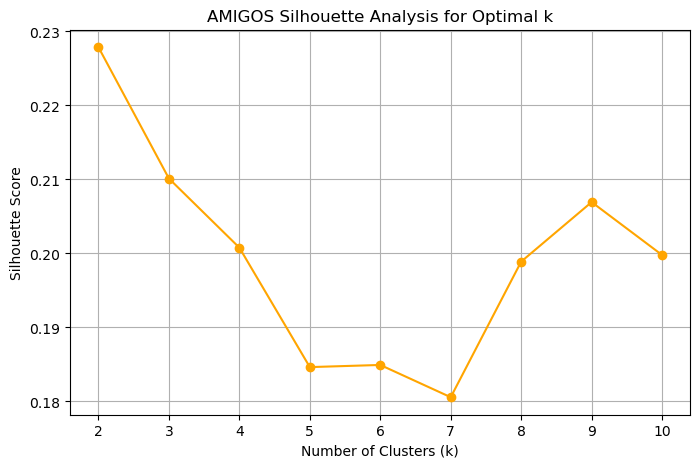

In [7]:
# Range of k to test
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    # Fit & predict directly on the scaled columns in df_a
    km = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=100, 
                random_state=42)
    
    labels = km.fit_predict(df_a[columns])
    
    # Compute silhouette for this k
    score = silhouette_score(df_a[columns], labels)
    sil_scores.append(score)
    print(f"k={k}: Silhouette={score:.3f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('AMIGOS Silhouette Analysis for Optimal k')
plt.grid(True)
plt.show()


After a silhouette analysis, we found that k-3 was the optimal number of clusters while limiting reasonable number of K. for example, 6, 7, 8 achieved lower silhouette scores, but that would divide the sample too much.

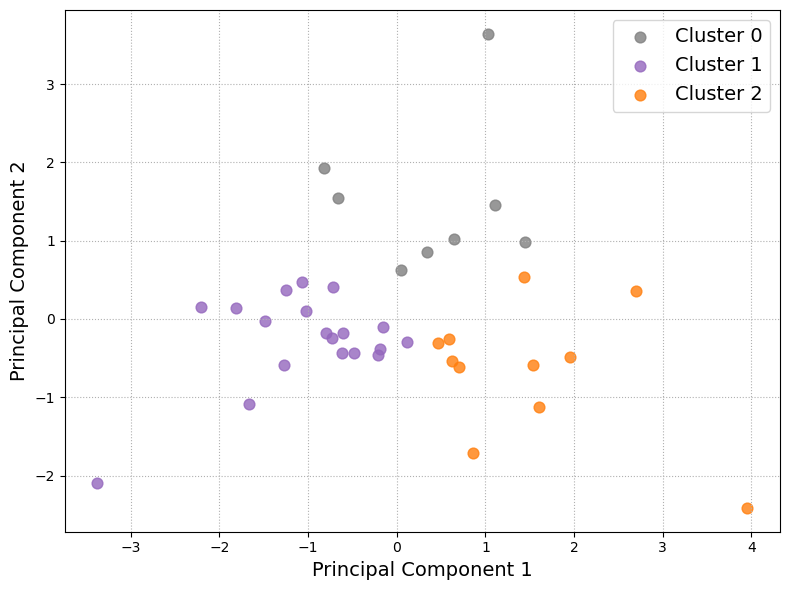

In [28]:
# PCA
pca = PCA(n_components=2, random_state=42)
df_a[['PC1', 'PC2']] = pca.fit_transform(df_a[columns])

# Setup
plt.figure(figsize=(8, 6))

# Choose discrete colormap
unique_clusters = sorted(df_a['K_Cluster'].unique())
cluster_color_map = {
    0: plt.get_cmap('tab20')(14),
    1: plt.get_cmap('tab20')(8),
    2: plt.get_cmap('tab20')(2),
}

# Plot each cluster
for cluster in unique_clusters:
    color = cluster_color_map[cluster]
    mask = df_a['K_Cluster'] == cluster
    plt.scatter(
        df_a.loc[mask, 'PC1'],
        df_a.loc[mask, 'PC2'],
        label=f"Cluster {cluster}",
        color=color,
        edgecolor=None,
        s=60,
        alpha=0.8
    )

# Final touches
# plt.title("K-Means Cluster Results of AMIGOS (PCA Projection)")
plt.xlabel("Principal Component 1", fontsize = 14)
plt.ylabel("Principal Component 2", fontsize = 14)
plt.grid(True, linestyle=':')  # dotted grid
plt.legend(title=None, fontsize = 14)
plt.tight_layout()
plt.show()


### Export for use

In [9]:
# take principal components for model input: cluster-wise PCA means. cluster assignment is stored in df_a['K_Cluster]
# Create DataFrame with cluster and PCA components
X_pca = pca.fit_transform(df_a[columns])
df_a['PC1'] = X_pca[:, 0]
df_a['PC2'] = X_pca[:, 1]

# 4. Compute cluster centroid on PC1, map back
pc1_means = df_a.groupby('K_Cluster')['PC1'].mean()
df_a['Cluster_PC1'] = df_a['K_Cluster'].map(pc1_means)

# optionally also centroid for PC2
pc2_means = df_a.groupby('K_Cluster')['PC2'].mean()
df_a['Cluster_PC2'] = df_a['K_Cluster'].map(pc2_means)


In [ ]:
# display(df_a)
df_a.to_pickle('AMIGOS_pers.pkl')

# Other cluster methods that did not work out

## DBSCAN clustering

In [11]:
# Grid of hyperparameters
param_grid = {
    'eps': np.linspace(0.5, 6.0, 12),  
    'min_samples': [2, 3, 4, 5, 6]
}

results = [] # store results

# iterate through all combinations, init fit DMSCAN
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(df_a)

    # Count clusters and noise
    n_clusters = len(set(labels) - {-1})
    n_noise = np.sum(labels == -1)
    noise_ratio = n_noise / len(labels)

    # Only compute silhouette if ≥ 2 clusters
    if n_clusters >= 2:
        try:
            mask = labels != -1
            if len(np.unique(labels[mask])) >= 2:
                sil_score = silhouette_score(df_a[mask], labels[mask])
            else:
                sil_score = -1
        except:
            sil_score = -1
    else:
        sil_score = -1

    results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': noise_ratio,
        'silhouette': sil_score
    })

# Best parameters:
# eps            1.000000
# min_samples    3.000000
# n_clusters     2.000000
# silhouette     0.427524

    eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
15  2.0            2           2       33     0.868421    0.941710
33  3.5            5           2       24     0.631579    0.863643
21  2.5            3           2       29     0.763158    0.779511
26  3.0            3           4       20     0.526316    0.655186
20  2.5            2           4       25     0.657895    0.649143

Using custom DBSCAN config: eps=4.5, min_samples=2


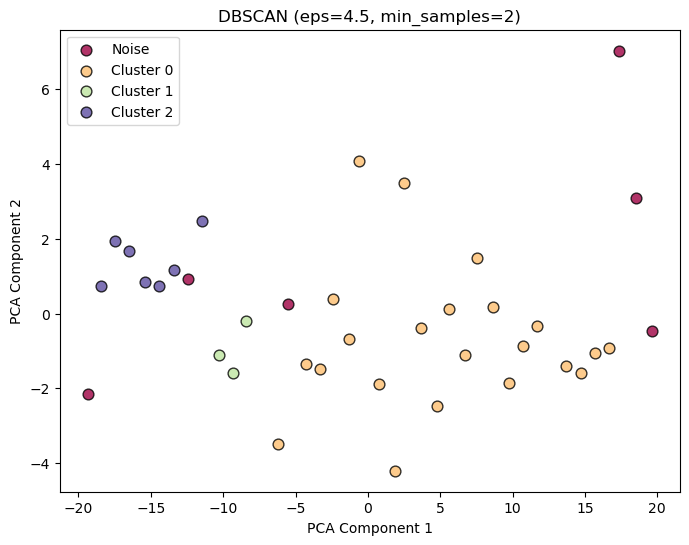

In [12]:
# Step 4: Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="silhouette", ascending=False)

# Show top results
print(results_df.head())

custom_eps = 4.5
custom_min_samples = 2

print(f"\nUsing custom DBSCAN config: eps={custom_eps}, min_samples={custom_min_samples}")
dbscan = DBSCAN(eps=custom_eps, min_samples=custom_min_samples)
labels = dbscan.fit_predict(df_a)

# PCA for visualization
X_pca = PCA(n_components=2).fit_transform(df_a)

# Plotting
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for k, col in zip(unique_labels, colors):
    mask = (labels == k)
    label_name = "Noise" if k == -1 else f"Cluster {k}"
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=col, edgecolor='k', s=60, label=label_name, alpha=0.8)

plt.title(f"DBSCAN (eps=4.5, min_samples=2)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

In [13]:
# Filter for acceptable noise levels and valid clustering
filtered = results_df.query("n_clusters >=3")

# Sort by silhouette score (descending)
filtered_sorted = filtered.sort_values(by="noise_ratio", ascending=True)

# Display top candidates
print("Top DBSCAN configurations (noise < 30%, ≥2 clusters):")
print(filtered_sorted.head())

# Select best config
best_config = filtered_sorted.iloc[0]
print("\nBest config (filtered):")
print(best_config)


Top DBSCAN configurations (noise < 30%, ≥2 clusters):
    eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
40  4.5            2           3        6     0.157895    0.339265
41  4.5            3           3        6     0.157895    0.339265
35  4.0            2           4        6     0.157895    0.165429
36  4.0            3           3        8     0.210526    0.348946
38  4.0            5           3       13     0.342105    0.531412

Best config (filtered):
eps            4.500000
min_samples    2.000000
n_clusters     3.000000
n_noise        6.000000
noise_ratio    0.157895
silhouette     0.339265
Name: 40, dtype: float64


The best parameter configuration has waaay too much noise -> the only other possible configurations are eps=1.0, min_samples=3 with 2 clusters (which also has crazy small clusters and a lot of noise) and eps=1.5, min_samples=2 with 3 clusters which is more reasonable. Either way, I can't seem to improve the balance in the clusters so DBSCAN may just be not the method for this data

## Check AMIGOS dist and compute shapiro score

In [14]:
# plot amigos (normal distribution )
# for i in range (5):
    # plt.hist(pers_amigos.iloc[i][1:], bins = 20, range = (0,7))
    # norm = scipy.stats.shapiro(x = pers_amigos.iloc[i][1:])
    # print(norm)
    # plt.show()
    

# Prepare Phymer for clustering
Facets don't seem normally distributed. 

In [15]:
# Load the raw personality CSV
pers_phymer = pd.read_csv(
    "/Users/anna/Downloads/Scriptie_code/PhyMER/PhyMER Dataset/Personality/big_5_personality_traits.csv",
    delimiter=",")
df_p = pers_phymer.copy()

# 1) Rename to match Amigos naming
df_p = df_p.rename(columns={
    "Openness to Experience": "Openness",
    "Extraversion":           "Extroversion",   # if you prefer that spelling
})

# 2) Extract ParticipantID from the index
df_p["ParticipantID"] = df_p.index + 1

# 3) Define the exact column order you want
phy_cols = [
    "ParticipantID",
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Openness",
    "Neuroticism"
]

# Reorder the DataFrame
df_p = df_p[phy_cols]

# Standardize the five trait dimensions
scaler = StandardScaler()
df_p[phy_cols[1:]] = scaler.fit_transform(df_p[phy_cols[1:]].astype(float))

display(df_p.head())

,ParticipantID,Extroversion,Agreeableness,Conscientiousness,Openness,Neuroticism
0,1,0.128209,-1.156105,-1.165998,-1.797939,0.367607
1,2,-0.421257,-0.596699,-1.165998,0.388744,-0.367607
2,3,0.677674,-0.596699,-1.165998,-0.704598,-1.102822
3,4,0.677674,0.522112,-0.529999,-1.069045,-1.102822
4,5,1.227139,-0.037294,-1.165998,-1.069045,-0.367607


## K-MEANS for PHYMER

In [16]:
# run k means
trait_cols = ["Extroversion", "Agreeableness", "Conscientiousness",
              "Openness", "Neuroticism"]

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
kmeans.fit(df_p[trait_cols])

df_p["K_Cluster"] = kmeans.labels_

# run internal quality metrics
sil = silhouette_score(df_p[trait_cols], df_p["K_Cluster"])
db  = davies_bouldin_score(df_p[trait_cols], df_p["K_Cluster"])
ch  = calinski_harabasz_score(df_p[trait_cols], df_p["K_Cluster"])

print(f"Silhouette score      : {sil:8.3f}")     
print(f"Davies-Bouldin index  : {db:8.3f}")      
print(f"Calinski-Harabasz     : {ch:8.1f}")     


Silhouette score      :    0.256
Davies-Bouldin index  :    1.383
Calinski-Harabasz     :      8.6


k=2: Silhouette=0.253
k=3: Silhouette=0.256
k=4: Silhouette=0.256
k=5: Silhouette=0.241
k=6: Silhouette=0.177
k=7: Silhouette=0.194
k=8: Silhouette=0.170
k=9: Silhouette=0.183
k=10: Silhouette=0.219


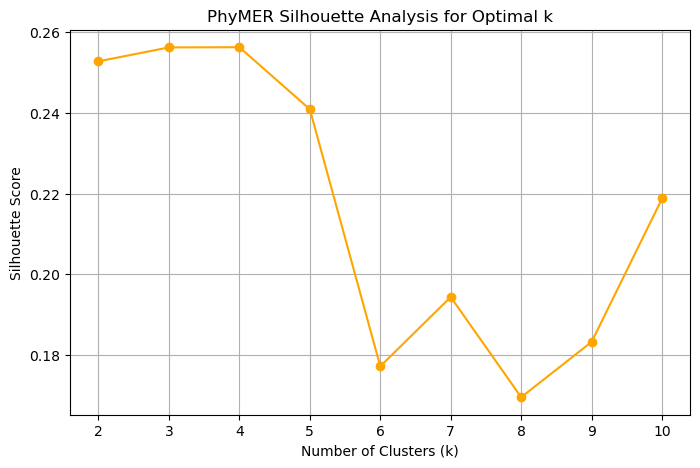

In [17]:
# we can determine the best number for K by plotting K to Silhouette score. We see that the optimal score is where k=3
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=100, random_state=42)
    kmeans.fit(df_p[trait_cols])
    score = silhouette_score((df_p[trait_cols]), kmeans.labels_)
    sil_scores.append(score)
    print(f"k={k}: Silhouette={score:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('PhyMER Silhouette Analysis for Optimal k')
plt.grid(True)
plt.show()


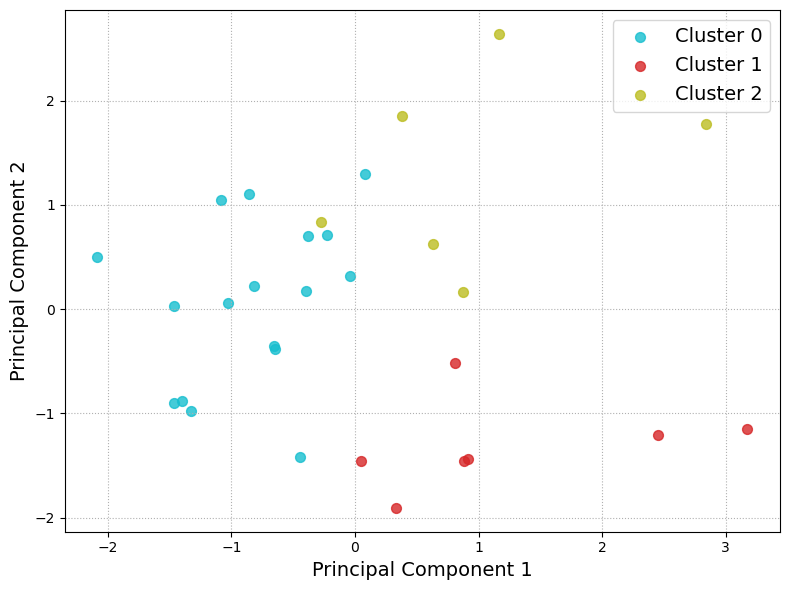

In [29]:
# Run PCA
pca = PCA(n_components=2)
phy_X_pca = pca.fit_transform(df_p[trait_cols])

# Set up plot
plt.figure(figsize=(8, 6))

# Plot each cluster separately to enable legend
unique_clusters = sorted(df_p['K_Cluster'].unique())
cluster_color_map = {
    0: plt.get_cmap('tab20')(18),
    1: plt.get_cmap('tab20')(6),
    2: plt.get_cmap('tab20')(16),
}
# cmap =plt.get_cmap("tab20")
# colors = [cmap(i) for i in range(len(unique_clusters))]

for cluster, color in zip(unique_clusters, colors):
    mask = df_p['K_Cluster'] == cluster
    plt.scatter(
        phy_X_pca[mask, 0], 
        phy_X_pca[mask, 1], 
        label=f"Cluster {cluster}", 
        color = cluster_color_map[cluster], 
        edgecolor=None, 
        s=50, 
        alpha=0.8
    )

# Add labels and legend
# plt.title("K-Means Clustering Results of PhyMER (PCA Projection)")
plt.xlabel("Principal Component 1", fontsize = 14)
plt.ylabel("Principal Component 2", fontsize = 14)
plt.legend(title=None, fontsize = 14)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


In [19]:
# compute principal component of all traits per person (basically, place in the plot that we see above)
df_p['PC1'] = phy_X_pca[:, 0]
df_p['PC2'] = phy_X_pca[:, 1]

# compute principal components of the cluster centroids & add to df
pc1_means = df_p.groupby('K_Cluster')['PC1'].mean()
df_p['Cluster_PC1'] = df_p['K_Cluster'].map(pc1_means)
# optionally also centroid for PC2
pc2_means = df_p.groupby('K_Cluster')['PC2'].mean()
df_p['Cluster_PC2'] = df_p['K_Cluster'].map(pc2_means)

In [20]:
df_p.head()

,ParticipantID,Extroversion,Agreeableness,Conscientiousness,Openness,Neuroticism,K_Cluster,PC1,PC2,Cluster_PC1,Cluster_PC2
0,1,0.128209,-1.156105,-1.165998,-1.797939,0.367607,0,-0.443488,-1.421001,-0.837315,0.072387
1,2,-0.421257,-0.596699,-1.165998,0.388744,-0.367607,1,0.807553,-0.517551,1.230035,-1.304334
2,3,0.677674,-0.596699,-1.165998,-0.704598,-1.102822,0,-0.646380,-0.380393,-0.837315,0.072387
3,4,0.677674,0.522112,-0.529999,-1.069045,-1.102822,0,-1.467570,0.024944,-0.837315,0.072387
4,5,1.227139,-0.037294,-1.165998,-1.069045,-0.367607,0,-1.327496,-0.977637,-0.837315,0.072387


In [21]:
df_p.to_pickle('personality_phymer.pkl')

# Clustering distribution visualization

In [22]:
# define trait order
trait_order = ['Extroversion', 'Agreeableness', 'Conscientiousness', 'Openness', 'Neuroticism']

def plot_cluster_traits(df, dataset_name, trait_order, cluster_col='K_Cluster', value_range=(-6, 5)):
    """ Plot violin plots of personality trait distributions per cluster.
    Args:
        df: DataFrame with standardized trait scores and cluster labels.
        dataset_name (str string for the plot (e.g., 'Amigos' or 'Phymer').
        trait_order (list): trait names to show on x-axis.
        cluster_col (str): Name of the column indicating cluster membership.
        value_range (tuple): y-axis limits.
    """
    # Melt the dataframe for long-format plotting
    melted = df.melt(id_vars=[cluster_col], value_vars=trait_order, var_name='Trait', value_name='Value'
    )

    # Determine number of clusters
    clusters = melted[cluster_col].unique()
    n_clusters = len(clusters)

    # Create subplots
    plt.figure(figsize=(5 * n_clusters, 6))
    for i, cluster in enumerate(sorted(clusters)):
        plt.subplot(1, n_clusters, i + 1)
        cluster_data = melted[melted[cluster_col] == cluster]
        sns.violinplot(data=cluster_data, x='Trait', y='Value', palette='tab20', edgecolor=None,  inner='quartile', order=trait_order, hue="Trait"
        )
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.title(f'Cluster {cluster}', fontsize=14)
        plt.xlabel(None)
        plt.ylabel('Z-scored trait value', fontsize=14)
        plt.xticks(rotation=45, fontsize=14)
        plt.ylim(*value_range)

    # plt.suptitle(f"{dataset_name} Cluster Trait Distributions", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


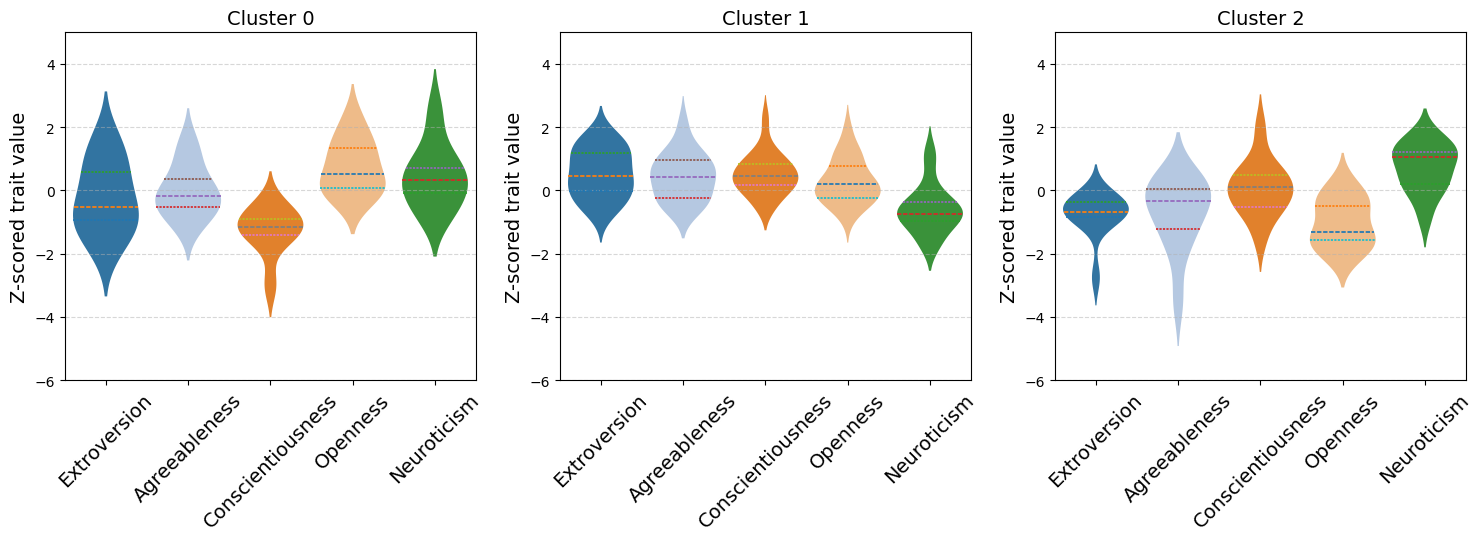

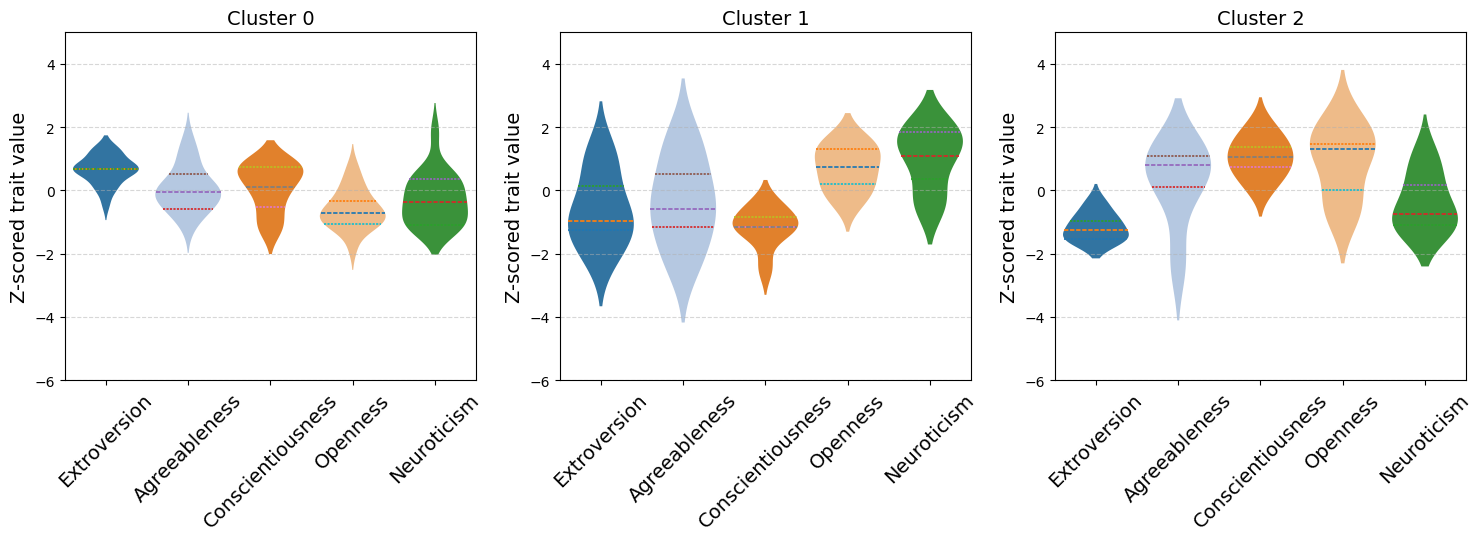

In [23]:
# For Amigos
plot_cluster_traits(df_a, "Amigos", trait_order)

# For Phymer
plot_cluster_traits(df_p, "Phymer", trait_order)


General tendencies (amigos)
- Cluster 0: High extraversion, mid-high agreeableness, mid conscientiousness, mid openness, low neuroticism, -> Extraverted, agreeable & stable people
- Cluster 1: Low extraversion, mid-low agreeableness, mid conscientiousness, mid-high openness, low neuroticism -> Introverted, stable, open people
- Cluster 2: low extraversion, mid agreeableness, mid conscientiousness, and low openness, high neuroticism -> Introverted, unstable people

General tendencies (phymer)
-  Cluster 0: High extraversion and low neuroticism. mid conscientiousness, low openness & mid agreeableness. -> extraverted, stable and less open
- Cluster 1: Low exraversion, high neuroticism. Low conscientiousness. High agreeable and mid openness -> introverted, unstable but agreeable
- Cluster 2: Low extraversion, mid neuroticism. mid conscientiousness, very low agreeableness but high openness.-> introverted, open, low agreeable people

In [24]:
# amigos
# Group by the cluster label and compute mean and std for each trait
summary = df_a.groupby('K_Cluster')[columns].agg(['mean', 'std'])
# print(summary)

# trait importance:
cluster_means = df_a.groupby('K_Cluster')[columns].mean() # mean
trait_variance = cluster_means.var(axis=0).sort_values(ascending=False) # compute trait variance and sort by importance

print("Trait importance based on between-cluster variance:")
print(trait_variance)

# phymer
# Group by the cluster label and compute mean and std for each trait
# summary = pers_phymer.groupby('K_Cluster')[phy_traits].agg(['mean', 'std'])
# print(summary)

# # Check trait variance/importance:
# cluster_means = pers_phymer.groupby('K_Cluster')[phy_traits].mean() # mean
# trait_variance = cluster_means.var(axis=0) # variance
# sorted_traits = trait_variance.sort_values(ascending=False) # sort by importance

# print("Trait importance based on between-cluster variance:") # how the clusters differentiate for each trait
# print(sorted_traits)


Trait importance based on between-cluster variance:
Conscientiousness    0.867898
Openness             0.846347
Neuroticism          0.480516
Extroversion         0.436877
Agreeableness        0.342461
dtype: float64


# K mediods

In [25]:
from sklearn_extra.cluster import KMedoids   
k = 3
kmedoids = KMedoids(n_clusters=k,
                    metric="manhattan",      # try 'cosine' or 'euclidean'
                    init="k-medoids++",
                    random_state=42)
labels = kmedoids.fit_predict(df_p)

# Attach labels back to the DataFrame
pers_phymer["KMedoids_Cluster"] = labels

sil = silhouette_score(df_p, labels, metric="cosine")
print("Cluster sizes:\n", pers_phymer["KMedoids_Cluster"].value_counts())
print(f"Silhouette (K‑Medoids, Manhattan) = {sil:.3f}")


# plt.figure(figsize=(15, 10))
# for i, trait in enumerate(phy_traits):
#     plt.subplot(2, 3, i + 1)
#     sns.violinplot(data=pers_phymer, x="KMedoids_Cluster", y=trait,
#                    palette="Set2", inner="quartile", hue="KMedoids_Cluster")
#     plt.title(f"{trait} (z‑score) by K‑Medoids cluster")
#     plt.xlabel("Cluster")
#     plt.ylabel("Z‑score")
# plt.tight_layout()
# plt.show()


Cluster sizes:
 KMedoids_Cluster
0    14
2     9
1     7
Name: count, dtype: int64
Silhouette (K‑Medoids, Manhattan) = -0.112


In [26]:
# Grid of hyperparameters
param_grid = {
    'eps': [1.0, 1.5, 2.0, 2.5, 3.0],
    'min_samples': [2, 3, 4, 5, 6]
}

results = [] # store results

# iterate through all combinations, init fit DMSCAN
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples']) 
    labels = dbscan.fit_predict(df_p) 
    unique_clusters = set(labels) # Count unique clusters 
    n_clusters = len(unique_clusters - {-1}) # exclude noise
    
    if n_clusters > 1: #  at least 2 clusters are needed for silhouette score.
        # sil_score = silhouette_score(phy_X_scaled, labels) # option: include noise points. silhouette turned out way worse: 0.0507
        
        if -1 in unique_clusters: #  if there are noise points, exclude them from the silhouette
            mask = labels != -1
            if len(set(labels[mask])) > 1: # when there are  at least 2 clusters that are non-noise
                sil_score = silhouette_score(df_p[mask], labels[mask])
            else:
                sil_score = -1  # not enough clusters
        else:
            sil_score = silhouette_score(df_p, labels)
    else:
        sil_score = -1  # = invalid clustering settings
    
    results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'silhouette': sil_score
    })

results_df = pd.DataFrame(results) # convert results to df so we can see all combinations
# display(results_df)

# Find the best parameter combination by silhouette score.
best_params = results_df.loc[results_df['silhouette'].idxmax()]
print("Best parameters:")
print(best_params)

#

Best parameters:
eps            3.000000
min_samples    2.000000
n_clusters     3.000000
silhouette     0.684535
Name: 20, dtype: float64


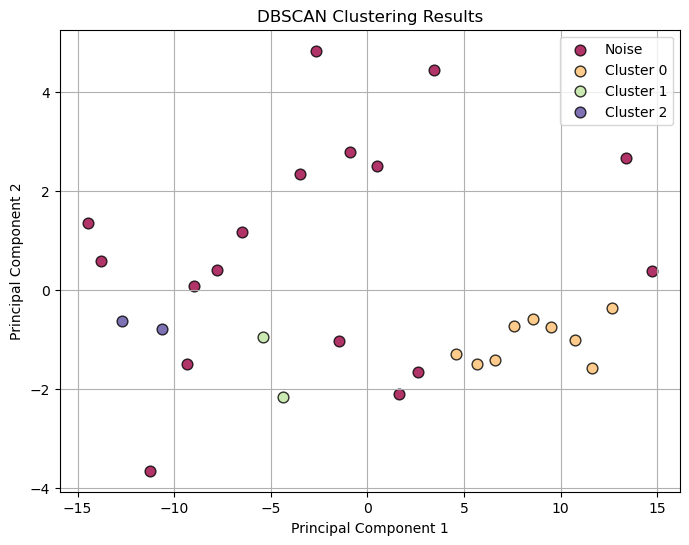

In [27]:
# Run DBSCAN with best params
db = DBSCAN(eps=3, min_samples=2).fit(df_p)
labels = db.labels_

# Reduce data to 2D for visualization
X_pca = PCA(n_components=2).fit_transform(df_p)

# Get unique labels and assign colors (black for noise)
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for k, col in zip(unique_labels, colors):
    mask = (labels == k)
    label_name = "Noise" if k == -1 else f"Cluster {k}"
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=col, edgecolor='k', s=60, label=label_name, alpha=0.8)

plt.title("DBSCAN Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()